In [1]:
!pip install pyDOE

#you need to add a dataset with GaussJacobiQuadRule_V3 on the right 
import sys
sys.path.insert(1, '/kaggle/input/quadrule')
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights

#import GaussJacobiQuadRule_V3


import tensorflow as tf
print(tf.version)
#tf.disable_v2_behavior()
import pyDOE

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
#from GaussJacobiQuadRule_V3.py import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time



2023-09-22 21:42:47.821676: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 21:42:47.822967: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 21:42:47.857422: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 21:42:47.858384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 21:42:48.457900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<module 'tensorflow._api.v2.version' from '/home/mariano/Documenti/test/base/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>


In [2]:
#types
float_type_tf=tf.float32
float_type_np=np.float32
print(str(float_type_tf))

<dtype: 'float32'>


In [43]:

# Suppose you have a list of dictionaries
data = [
    {'feature1': [1, 2], 'feature2': [3, 4, 5]},
    {'feature1': [5, 6], 'feature2': [7, 8, 5]}
]

# Convert the list of dictionaries into a dictionary of tensors
# This assumes all the dictionary values have the same shape
data_dict = {
    key: tf.constant([d[key] for d in data])
    for key in data[0].keys()
}

# Create a dataset from the dictionary
dataset = tf.data.Dataset.from_tensor_slices(data_dict)

# You can now use the dataset for further processing
for element in dataset:
    print(element["feature2"])

tf.Tensor([3 4 5], shape=(3,), dtype=int32)
tf.Tensor([7 8 5], shape=(3,), dtype=int32)


In [3]:
class parameters:
    def __init__(self,LR,Opt_Niter,N_Element,N_testfcn,N_Quad,lossb_weight,a,b):
        self.LR = LR
        self.Opt_Niter = Opt_Niter + 1
        self.Opt_tresh = 2e-32
        self.var_form=2
        self.N_Element = N_Element
        self.N_testfcn = N_testfcn #number of test function
        self.N_Quad = N_Quad    #quadrature points 
        self.lossb_weight = lossb_weight #hyprparameter we may turn it up

        #params for the exact sol and boundary term
        self.omega = 8*np.pi
        self.amp = 1
        self.r1 = 80

        #ingredients for loss
        [self.x_quad, self.w_quad] = GaussLobattoJacobiWeights(N_Quad, 0, 0)
        

        self.test_quad_element = self.Test_fcn(self.N_testfcn, self.x_quad)
        self.d1test_quad_element, self.d2test_quad_element = self.dTest_fcn(self.N_testfcn, self.x_quad)


        [self.x_l, self.x_r] = [a, b]     #modify in the future if you want general (a,b) interval
        self.delta_x = (self.x_r - self.x_l)/N_Element
        self.grid = np.asarray([ self.x_l + i*self.delta_x for i in range(self.N_Element+1)])

        #build right side (it doesnt depend on the network)

        self.F_ext_total = []
        for e in range(self.N_Element):
            x_quad_element = self.grid[e] + (self.grid[e+1]-self.grid[e])/2*(self.x_quad+1)  #traslation of the element 

            jacobian = (self.grid[e+1]-self.grid[e])/2
            testfcn_element = np.asarray([ self.Test_f(n,self.x_quad)  for n in range(1, self.N_testfcn+1)])

            #this is fh calculated on the real nodal values summed over each real nodal values(which comes form CGL nodes )

            f_quad_element = self.f_ext(x_quad_element)
            F_ext_element  = jacobian*np.asarray([sum(self.w_quad*f_quad_element*testfcn_element[i]) for i in range(self.N_testfcn)])    
            F_ext_element = F_ext_element[:,None] 
            self.F_ext_total.append(F_ext_element)

        self.F_ext_total = np.asarray(self.F_ext_total)


        self.X_bound = np.asarray([a,b],dtype=float_type_np)[:,None]
        self.u_bound   = self.u_exact(self.X_bound)

    def u_exact(self,x):
        utemp = 0.1*np.sin(self.omega*x) + np.tanh(self.r1*x)
        return self.amp*utemp

    def f_ext(self,x):
        gtemp =  -0.1*(self.omega**2)*np.sin(self.omega*x) - (2*self.r1**2)*(np.tanh(self.r1*x))/((np.cosh(self.r1*x))**2)
        return -self.amp*gtemp

    def Test_f(self,n,x):
        test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
        return test
    
    def Test_fcn(self, N_test,x):
        test_total = []
        for n in range(1,N_test+1):  
            test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
            test_total.append(test)
        return np.asarray(test_total)

    def dTest_fcn(self, N_test,x):  #valuete the first and second derivatives of test functions on a point x 
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):  
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)

In [4]:
params=parameters(0.001,5000,5,20,100,1,-1,1)

/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


In [5]:
tfk=tf.keras
tfkl=tf.keras.layers
input_shape=(1,)
seed=53
input_layer = tfkl.Input(shape=input_shape, name='Input')
x1 = tfkl.Dense(20, activation=tf.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(input_layer)
x2 = tfkl.Dense(20, activation=tf.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x1)
x3 = tfkl.Dense(20, activation=tf.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x2)
x3 = tfkl.Dense(20, activation=tf.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x2)
output_layer = tfkl.Dense(1, activation='linear', kernel_initializer = tfk.initializers.GlorotUniform(seed))(x3)

In [6]:
model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 901 (3.52 KB)
Trainable params: 901 (3.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:


element_data=[]

for e in range(params.N_Element):
    data_dict = {
        'F_ext_element': 1,
    }

    element_data.append(data_dict)

# Create a dataset from the list of dictionaries

dataset = tf.data.Dataset.from_tensor_slices(element_data)

ValueError: Attempt to convert a value ({'F_ext_element': 1}) with an unsupported type (<class 'dict'>) to a Tensor.

In [38]:
#pre training
F_ext_element=[]
Ntest_element=[]
x_quad_element=[]
jacobian=[]
x_b_element=[]
test_quad_element=[]
d1test_quad_element=[]
d2test_quad_element=[]
d1test_bound_element=[]
d2test_bound_element=[]


for e in range(params.N_Element):
    temp=tf.convert_to_tensor(params.F_ext_total[e],float_type_tf)
    F_ext_element.append(temp)
    n=np.shape(temp)[0]
    Ntest_element.append(n) #for each element of the grid you have a vector of the focing term (suppose its n-loc),so the you can have at most quad formula n_loc


    x_quad_element.append(tf.convert_to_tensor(params.grid[e] + (params.grid[e+1]-params.grid[e])/2*(params.x_quad+1),float_type_tf))

    #to change change integral to the ref segment in (-1,1)
    jacobian.append((params.grid[e+1]-params.grid[e])/2)



    temp=tf.convert_to_tensor(np.array([[params.grid[e]], [params.grid[e+1]]]),float_type_tf)
    x_b_element.append(temp)


    test_quad_element.append(tf.convert_to_tensor(params.Test_fcn(n, params.x_quad),float_type_tf))
    d1, d2 = tf.convert_to_tensor(params.dTest_fcn(n, params.x_quad),float_type_tf)
    d1test_quad_element.append(d1)
    d2test_quad_element.append(d2)


    a, b = tf.convert_to_tensor(params.dTest_fcn(n, np.array([[-1],[1]])),tf.float32)

    d1test_bound_element.append(a)
    d2test_bound_element.append(b)

tools_for_training={
"F_ext_element":F_ext_element,
"Ntest_element":Ntest_element,
"x_quad_element":x_quad_element,
"jacobian":jacobian,
"x_b_element":x_b_element,
"test_quad_element":test_quad_element,
"d1test_quad_element":d1test_quad_element,
"d2test_quad_element":d2test_quad_element,
"d1test_bound_element":d1test_bound_element,
"d2test_bound_element":d2test_bound_element
}


In [ ]:
@tf.function
def grad(x):
    with tf.GradientTape() as tape_:
        tape_.watch(x)
        with tf.GradientTape() as tape:
            tape.watch(x)
            y = model(x)
        d1=tape.gradient(y,x)
    d2=tape_.gradient(d1,x)
    return d2,d1

In [ ]:
@tf.function
def calculate_loss():
 varloss_total = 0.0

 for e in range(params.N_Element):




    d2u_NN_quad_element,d1u_NN_quad_element=grad(x_quad_element[e])



    if params.var_form == 1:
        U_NN_element = tf.reshape(tf.stack([-jacobian[e]*tf.reduce_sum(params.w_quad*d2u_NN_quad_element*test_quad_element[e][i]) \
                                        for i in range(Ntest_element[e])]),(-1,1))
    
        
    if params.var_form == 2:
        U_NN_element = tf.reshape(tf.stack([tf.reduce_sum(params.w_quad*d1u_NN_quad_element*d1test_quad_element[e][i]) \
                                        for i in range(Ntest_element[e])]),(-1,1)) 

    if params.var_form == 3:
        u_NN_bound_element=model(x_b_element[e])
        U_NN_element = tf.reshape(tf.stack([-1/jacobian[e]*tf.reduce_sum(params.wquad*u_NN_quad_element*d2test_quad_element[e][i]) \
                                            +1/jacobian[e]*tf.reduce_sum(u_NN_bound_element*np.array([-d1test_bound_element[e][i][0], d1test_bound_element[e][i][-1]]))  \
                                            for i in range(Ntest_element[e])]),(-1,1))
        
        
    Res_NN_element = U_NN_element - F_ext_element[e]
    loss_element = tf.reduce_mean(tf.square(Res_NN_element))
    varloss_total = varloss_total + loss_element






 lossb = tf.reduce_mean(tf.square(model(params.X_bound) - params.u_bound))   #u_NN_pred is what your network has calc,while u_tf is the real value
 return lossb,varloss_total

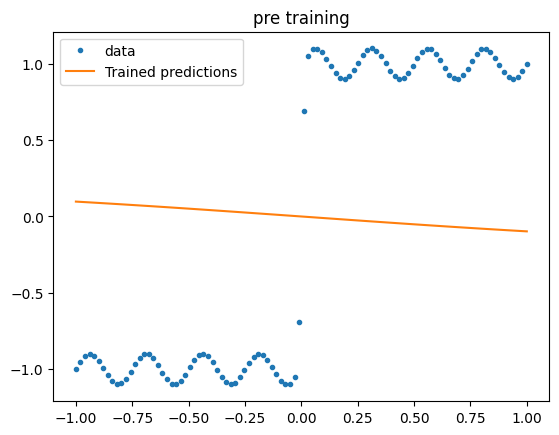

In [ ]:
x_test=tf.convert_to_tensor(np.linspace(-1,1,100),tf.float32)
y_test=params.u_exact(x_test)

plt.plot(x_test,y_test, '.', label="data")
plt.plot(x_test, model(x_test), label='Trained predictions')
plt.title('pre training')
plt.legend();

In [ ]:
epochs=params.Opt_Niter
total_record=[]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

start_time       = time.time()
for epoch in range(epochs+1):
    with tf.GradientTape() as tape:
        loss_valueb,loss_valuev=calculate_loss()
        loss=loss_valueb*params.lossb_weight+loss_valuev
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Print training loss for this epoch
    if (epoch) % 100 == 0:
                elapsed = time.time() - start_time
                str_print = 'It: %d, Lossb: %.3e, Lossv: %.3e, Time: %.2f'
                print(str_print % (epoch, loss_valueb, loss_valuev, elapsed))
                start_time = time.time()        
                total_record.append(np.array([epoch, loss,loss_valueb,loss_valuev]))

It: 0, Lossb: 1.204e+00, Lossv: 8.660e+02, Time: 2.25
It: 100, Lossb: 4.281e-07, Lossv: 8.660e+02, Time: 1.50
It: 200, Lossb: 3.130e-03, Lossv: 8.649e+02, Time: 1.53
It: 300, Lossb: 1.842e-01, Lossv: 6.063e+02, Time: 1.64
It: 400, Lossb: 9.182e-02, Lossv: 2.768e+02, Time: 1.59
It: 500, Lossb: 2.060e-03, Lossv: 2.681e+01, Time: 1.64
It: 600, Lossb: 2.001e-03, Lossv: 6.112e+00, Time: 1.51
It: 700, Lossb: 1.542e-04, Lossv: 3.075e+00, Time: 1.62
It: 800, Lossb: 6.874e-05, Lossv: 2.229e+00, Time: 1.45
It: 900, Lossb: 1.008e-06, Lossv: 1.750e+00, Time: 1.47
It: 1000, Lossb: 6.754e-06, Lossv: 1.366e+00, Time: 1.48
It: 1100, Lossb: 2.261e-06, Lossv: 1.014e+00, Time: 1.41
It: 1200, Lossb: 1.059e-06, Lossv: 7.463e-01, Time: 1.44
It: 1300, Lossb: 7.147e-08, Lossv: 5.709e-01, Time: 1.47
It: 1400, Lossb: 1.807e-06, Lossv: 4.587e-01, Time: 1.43
It: 1500, Lossb: 4.095e-06, Lossv: 3.703e-01, Time: 1.43
It: 1600, Lossb: 2.945e-06, Lossv: 3.101e-01, Time: 1.41
It: 1700, Lossb: 2.078e-06, Lossv: 2.654e-0

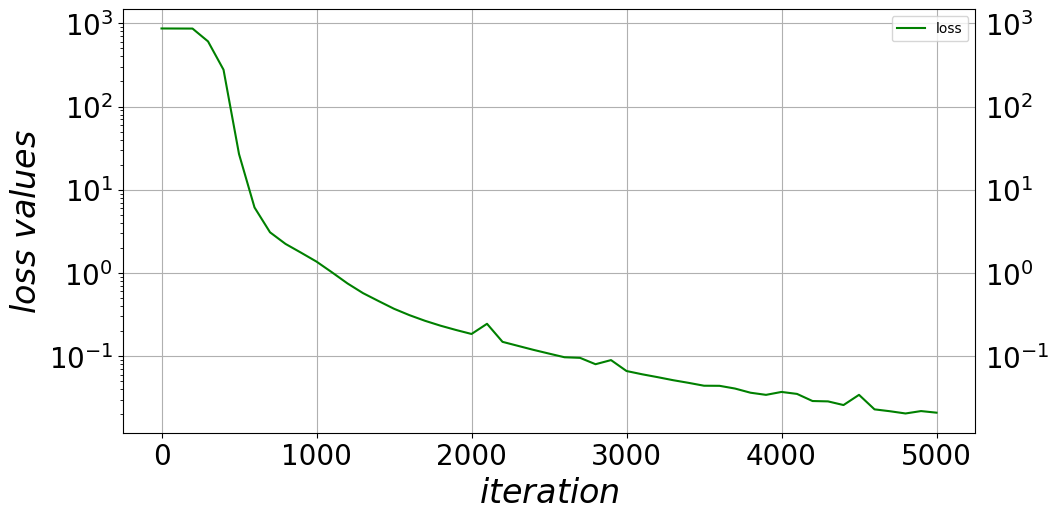

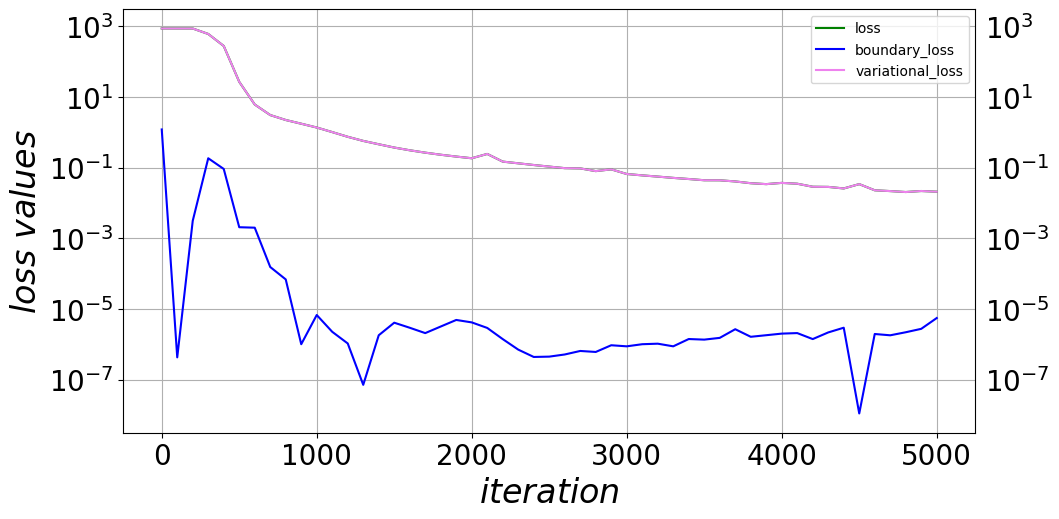

In [ ]:
font = 24
#all loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off') 
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()
# plt.savefig('loss.pdf')
#++++++++++++++++++++++++++++
#partial loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
loss_b  = [total_record[i][2] for i in range(len(total_record))]
loss_v  = [total_record[i][3] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.plot(iteration, loss_b,'blue',label="boundary_loss")
plt.plot(iteration, loss_v, 'violet',label="variational_loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()

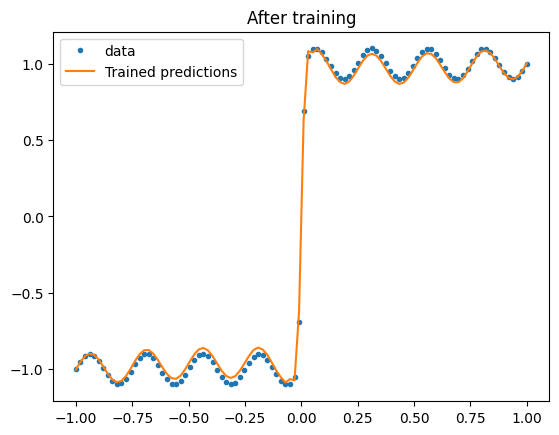

In [ ]:
x_test=tf.convert_to_tensor(np.linspace(-1,1,100),tf.float32)
y_test=tf.convert_to_tensor(params.u_exact(x_test))

plt.plot(x_test,y_test, '.', label="data")
plt.plot(x_test, model(x_test), label='Trained predictions')
plt.title('After training')
plt.legend();

<Figure size 640x480 with 0 Axes>

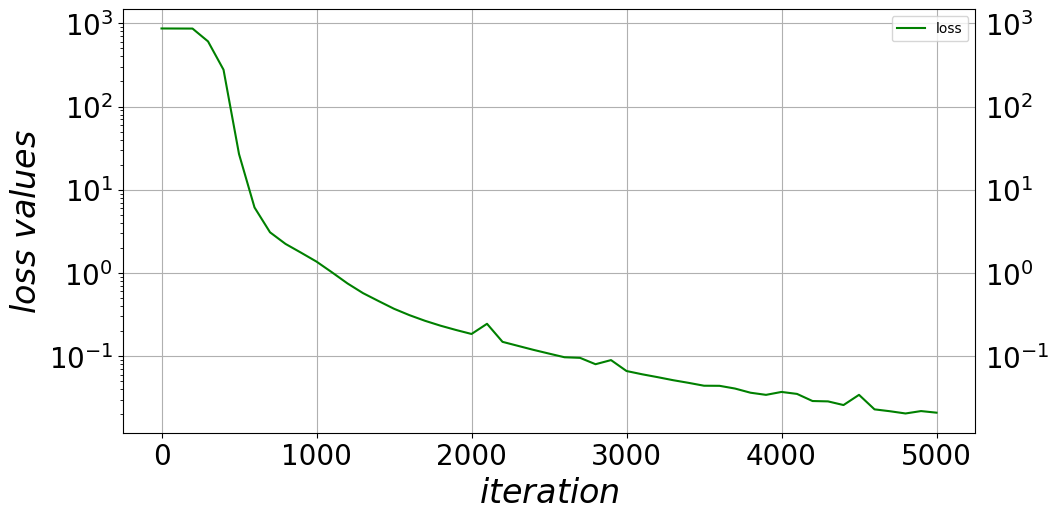

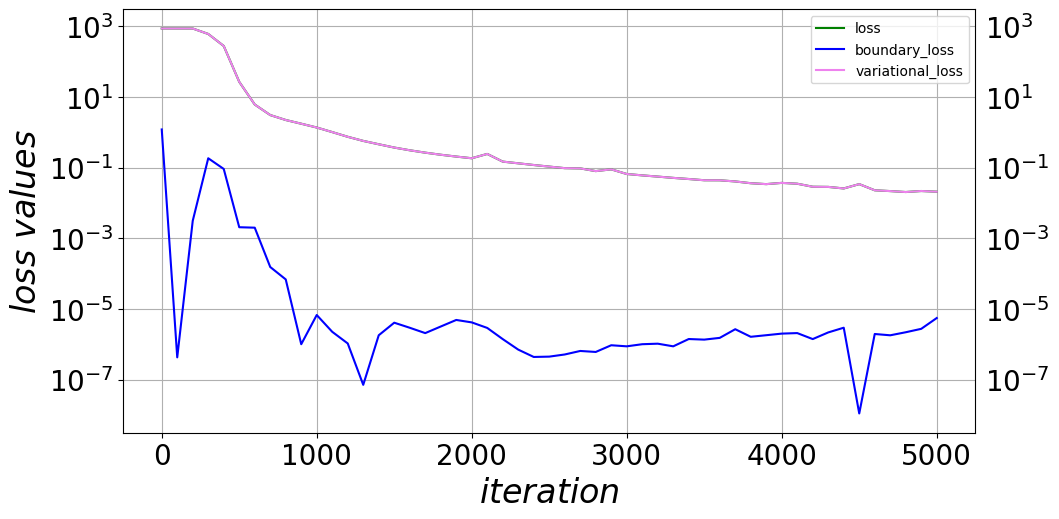

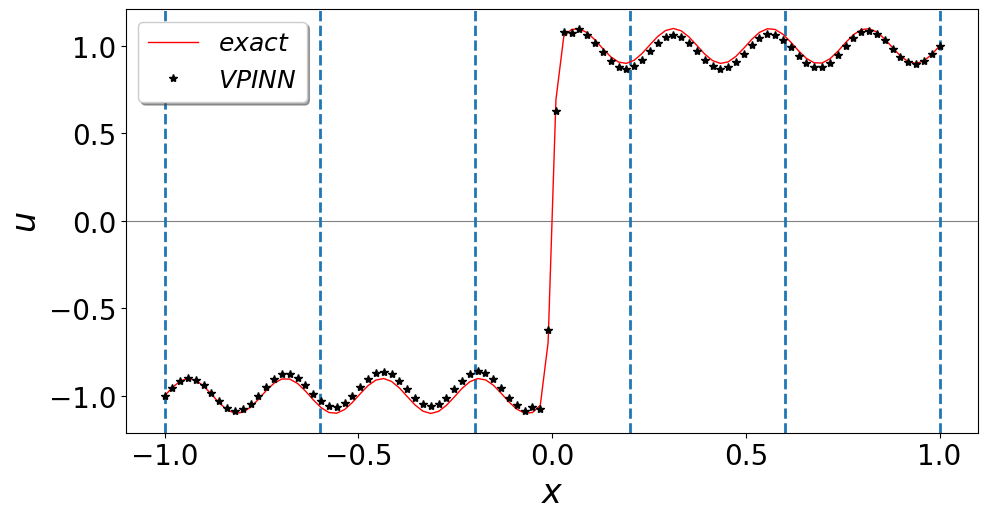

/tmp/ipykernel_14240/878080555.py:79: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.axvline(x=xc, linewidth=2, ls = '--')


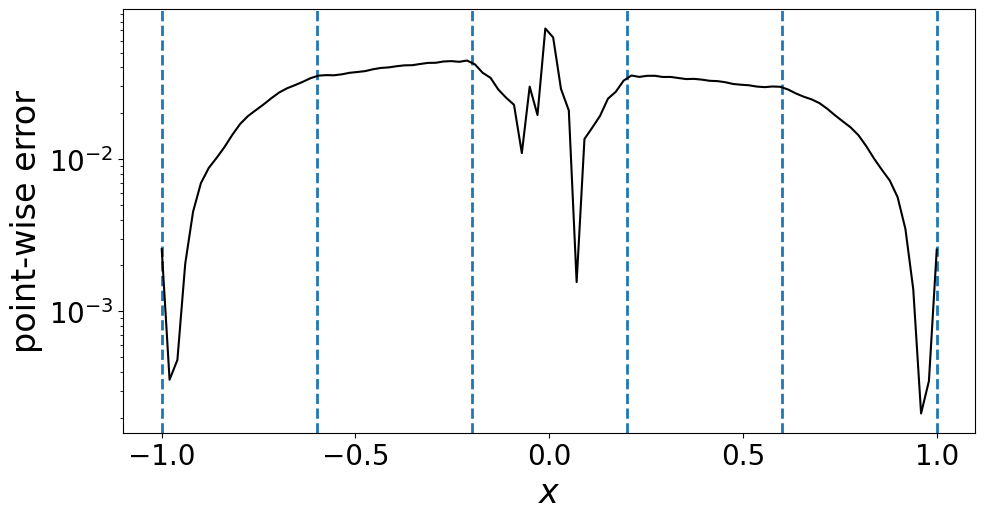

In [ ]:

x_test=tf.convert_to_tensor(np.linspace(-1,1,100),tf.float32)
y_test=tf.convert_to_tensor(params.u_exact(x_test))


u_pred=model(x_test)
y_test=tf.expand_dims(y_test,axis=1)

fig = plt.figure(0)
gridspec.GridSpec(3,1)


# plt.savefig('Train-Quad-pnts.pdf')    
#++++++++++++++++++++++++++++

font = 24
#all loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off') 
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()
# plt.savefig('loss.pdf')
#++++++++++++++++++++++++++++
#partial loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
loss_b  = [total_record[i][2] for i in range(len(total_record))]
loss_v  = [total_record[i][3] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.plot(iteration, loss_b,'blue',label="boundary_loss")
plt.plot(iteration, loss_v, 'violet',label="variational_loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()


pnt_skip = 25
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)

plt.xlabel('$x$', fontsize = font)
plt.ylabel('$u$', fontsize = font)
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in params.grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(x_test, y_test, linewidth=1, color='r', label=''.join(['$exact$']))
plt.plot(x_test, u_pred, 'k*', label='$VPINN$')
plt.tick_params( labelsize = 20)
legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
fig.set_size_inches(w=11,h=5.5)
plt.show()
# plt.savefig('prediction.pdf')
#++++++++++++++++++++++++++++

fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)
plt.xlabel('$x$', fontsize = font)
plt.ylabel('point-wise error', fontsize = font)
plt.yscale('log')
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in params.grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(x_test, abs(y_test - u_pred), 'k')
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()